# Short tour of Julia for GPU programming and Machine Learning

[Julia](https://julialang.org/) is a scientific programming language that is free and open source for downloads, documentation, learning resources etc. Bridging high-level interpreted and low-level compiled languages, it offers high performance (comparable to C and Fortran) without sacrificing simplicity and programming productivity (like in Python or R).

Julia has a rich ecosystem of libraries aimed towards scientific computing and a powerful built-in package manager to install and manage their dependencies. Julia is also gaining ground in HPC as it supports both multithreaded and distributed-memory parallelisation, as well as GPU computing.

ENCCS offers learning materials for Julia programming:
- [Introduction to programming in Julia](https://enccs.github.io/julia-intro/)
- [Julia for High-Performance Data Analytics](https://enccs.github.io/julia-for-hpda/)
- [Julia for High-Performance Scientific Computing](https://enccs.github.io/julia-for-hpc/)

## Short intro to GPU architecture

GPUs are high-throughput accelerators separate from the main processor (CPU). They were originally developed to support the highly parallel computations needed for graphics processing, but are nowadays used to accelerate memory-local floating-point workloads. A GPU has a lot less control units and most of the die size is dedicated to floating point units, which execute tens of thousands of threads simultaneously. Data has to be manually moved from the *host* memory (i.e. RAM) to the *device* memory (i.e. video RAM, VRAM), which can be a performance bottleneck. Using GPUs makes sense when the performance gain from the parallel computation shadows the cost of data transfer to/from the accelerator. A comparison between CPU and GPU architectures is shown in the figure below:

<div>
<img src="https://enccs.github.io/gpu-programming/_images/CPUAndGPU.png" width="800"/>
<p>Ref: <a src="https://enccs.github.io/gpu-programming/">ENCCS GPU programming lessons</a> </p>
</div>

Each thread has a local memory. Cores are grouped into streaming multiprocessors (CUDA)/compute units (ROCm), with a shared (CUDA)/private (ROCm) memory.

## Julia and the two language problem

To run code in any programming language, some sort of translation into machine instructions needs to take place, but how this translation takes place differs between programming languages:
- Interpreted languages like Python and R translate instructions line by line.
- Compiled languages like C/C++ and Fortran are translated by a compiler prior to program execution.

The benefits of interpreted languages are that they are easier to read and write because less information on aspects like types and array sizes needs to be provided. Programmer productivity is thus higher in interpreted languages, but compiled languages can perform faster by orders of magnitude because the compiler can perform optimizations during the translation to assembly. It is often the case that a high-level language is used for rapid prototyping and then the algorithm is rewritten in a compiled language for performance. This is also known as the *two-language problem*.

In many ways Julia looks like an interpreted language, and mostly behaves like one. But before each function is executed, Julia’s LLVM compiler will compile it `“just in time” (JIT)`. More on that later. Thus, it gives the flexibility of an interpreted language and the execution speed of a compiled language at the cost of waiting a bit longer for the first execution of any function.

Julia has been designed to be both fast and dynamic. In the words of its developers: 

> We want a language that’s open source, with a liberal license. We want the speed of C with the dynamism of Ruby. We want a language that’s homoiconic, with true macros like Lisp, but with obvious, familiar mathematical notation like Matlab. We want something as usable for general programming as Python, as easy for statistics as R, as natural for string processing as Perl, as powerful for linear algebra as Matlab, as good at gluing programs together as the shell. Something that is dirt simple to learn, yet keeps the most serious hackers happy. We want it interactive and we want it compiled. (Did we mention it should be as fast as C?).

## Julia Micro-Benchmarks

<div>
<img src="https://julialang.org/assets/images/benchmarks.svg", width="800"/>
</div>

# 1. Basic syntax

## Scalars

In [25]:
A = 3.14
println(A, " --- ", typeof(A))

B = 10
println(B, " --- ", typeof(B))

C = true
println(C, " --- ", typeof(C))

D = 3+4im
println(D, " --- ", typeof(D))

E = "Hello, Julia"
println(E, " --- ", typeof(E))

# supertypes and subtypes
print(supertypes(Float64), " --- ", subtypes(Int64))

3.14 --- Float64
10 --- Int64
true --- Bool
3 + 4im --- Complex{Int64}
Hello, Julia --- String
(Float64, AbstractFloat, Real, Number, Any) --- Type[]

## Vectors and Arrays

In [26]:
a1 = [1, 2, 3, 4] # 4-element Vector{Int64}
a2 = [i^3 for i in [1,2,3,4]] # Array comprehension

m1 = [[1,2]  [4,5]  [7,8]] # 2×3 Matrix{Int64}
m2 = zeros(4,4,4,4) # Zero 4×4×4×4 Array{Float64, 4}

# broadcasting
b1 = a1.^2
b2 = a2 .- a1

4-element Vector{Int64}:
  0
  6
 24
 60

## Structs
We can also create a composite type (a struct), and create a new method for that type. The `Point` composite type below is furthermore *parametric*, where we restrict the type T to be a subtype of `Real`:

In [27]:
struct Point{T<:Real}
    x::T
    y::T
end

## Loops and Conditionals

`for` loops iterate over iterables, including types like `Range`, `Array`, `Set` and `Dict`.

In [28]:
for i in [1,2,3,4,5]
    println("i = $i")
end

i = 1
i = 2
i = 3
i = 4
i = 5


In [29]:
A = [1 2; 3 4]
# visit each index of A efficiently
for i in eachindex(A)
    println("i = $i, A[i] = $(A[i])")
end

i = 1, A[i] = 1
i = 2, A[i] = 3
i = 3, A[i] = 2
i = 4, A[i] = 4


In [30]:
for (k, v) in Dict("A" => 1, "B" => 2, "C" => 3)
    println("$k is $v")
end

B is 2
A is 1
C is 3


In [31]:
x = 6
if x > 5
    println("x > 5")
elseif x < 5    # optional elseif
    println("x < 5")
else            # optional else
    println("x = 5")
end

x > 5


In [ ]:
n = 0
while n < 10
    n += 1
    println(n)
end

## Working with files

In [32]:
open("myfile.txt", "w") do f
    write(f, "a line")
end

open("myfile.txt") do f
    # read from file
    lines = readlines(f)
    println(lines)
end

["a line"]


## Functions

In [33]:
function f(x,y)
    x + y   # can also use "return" keyword
end

f(3, 5)

8

In [34]:
## Keyword arguments can be added after `;`

function greet_dog(; greeting = "Hi", dog_name = "Fido")  # note the ;
    println("$greeting $dog_name")
end

greet_dog(dog_name = "Coco", greeting = "Go fetch")

Go fetch Coco


In [35]:
# Optional arguments

function date(y, m=2, d=2)
    month = lpad(m, 2, "0")  # lpad pads from the left
    day = lpad(d, 2, "0")
    println("$y-$month-$day")
end

date(2024)
date(2024, 3)
date(2024, 3, 3)

2024-02-02
2024-03-02
2024-03-03


In [ ]:
# argument types can be specified explicitly
# This is not really needed as things will be JITed automatically without input 
# needed
function f(x::Float64, y::Float64)
    return x*y
end

# return types can also be specified
function g(x, y)::Int8
    return x * y
end

# 2. Special features of Julia

## Hierarchy Types

Julia is a dynamically typed language and does not require users to explicitly declare types because types are inferred and used at runtime. The sophisticated type system helps Julia to generate efficient code.

As types play a fundamental role in Julia’s design, it’s important to have a mental model of Julia’s type system. There are two basic kinds of types in Julia:
- Abstract types which define the type hierarchy and interface that types have to expose;
- Concrete types which describe data structures, that is, concrete implementations that can be used for variables.

Furthermore, a **primitive type** consists of plain bits such as an integer, character or floating point number. A **parametric type** represents a set of types. Types in Julia form a “type tree”, in which the leaves are concrete types.
For example, `Array` types can be concrete `DenseArray`, `SparseArray`, `CuArray`, but they all descend from `AbstractArray` as a supertype. An informal [interface](https://docs.julialang.org/en/v1/manual/interfaces/) system is used for composability.

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d9/Julia-number-type-hierarchy.svg/1920px-Julia-number-type-hierarchy.svg.png" width="800"/>
</div>

## Functions and Methods

In [36]:
function sumsquare(x, y)
    return x^2 + y^2
end

sumsquare (generic function with 1 method)

Each function can have multiple methods. A method is a function defined for specific arguments types.
Here we define methods using short form syntax.

In [37]:
sumsquare(x::Float64, y::Float64) = x^2 + y^2
sumsquare(x::Int64, y::Int64) = x^2 + y^2
sumsquare(x::Complex{Float64}, y::Complex{Float64}) = x^2 + y^2

sumsquare (generic function with 4 methods)

Julia’s type system also enables `multiple dispatch`, that is, choosing the most specific method of a function based on the argument types. 

`Multiple dispatch` sets the language apart from most other languages and makes it composable and fast when combined with just-in-time (JIT) compilation using the LLVM compiler toolchain.

In [38]:
# Passing arguments with all kinds of types to this function

# Int64
println(sumsquare(2, 3))

# Float64
println(sumsquare(2.72, 3.83))
    
# Complex{Float64}
println(sumsquare(1.2+2.3im, 2.1-1.5im))

13
22.067300000000003
-1.689999999999999 - 0.7800000000000011im


This can also be extended to composite types, e.g. we can now create two variables of type `Point`, and define a method for `sumsquare` which accepts this type:

In [39]:
function sumsquare(p1::Point, p2::Point)
   return Point(p1.x^2 + p2.x^2, p1.y^2 + p2.y^2)
end

p1, p2 = Point(1.0, 2.0), Point(2.0, 3.0)
sumsquare(p1, p2)  

Point{Float64}(5.0, 13.0)

## Metaprogramming

Julia represents its own code as a data structure accessible from the language itself. Since code is represented by objects that can be created and manipulated from within the language, it is possible for a program to transform and generate its own code, that is to create powerful macros (the term "metaprogramming" refers to the possibility to write code that writes code that is then evaluated).

Note the difference from C or C++ macros. There, macros work performing textual manipulation and substitution before any actual parsing or interpretation occurs.

In Julia, macros work when the code has already been parsed and organised in a syntax tree, and hence the semantic is much richer and allows for much more powerful manipulations.
For example, the `@btime` macro can pre prefixed to any code line/block to automatically generate and execute benchmarking code for a given snippet.
There is an aptly named `@macroexpand` macro that shows the effect of one macro, e.g.:

In [40]:
@macroexpand @assert 1===1

:(if 1 === 1
      nothing
  else
      Base.throw(Base.AssertionError("1 === 1"))
  end)

In [41]:
@macroexpand @btime m1 * m1'

quote
    #= /cfs/klemming/home/f/fiusco/.julia/packages/BenchmarkTools/QNsku/src/execution.jl:665 =#
    local var"##371" = begin
                #= /cfs/klemming/home/f/fiusco/.julia/packages/BenchmarkTools/QNsku/src/execution.jl:496 =#
                BenchmarkTools.generate_benchmark_definition(Main, Symbol[], Any[], Symbol[], (), $(Expr(:copyast, :($(QuoteNode(:(m1 * m1')))))), $(Expr(:copyast, :($(QuoteNode(nothing))))), $(Expr(:copyast, :($(QuoteNode(nothing))))), BenchmarkTools.Parameters())
            end
    #= /cfs/klemming/home/f/fiusco/.julia/packages/BenchmarkTools/QNsku/src/execution.jl:666 =#
    (BenchmarkTools).tune!(var"##371")
    #= /cfs/klemming/home/f/fiusco/.julia/packages/BenchmarkTools/QNsku/src/execution.jl:667 =#
    local (var"##372", var"##373") = (BenchmarkTools).run_result(var"##371"; warmup = false)
    #= /cfs/klemming/home/f/fiusco/.julia/packages/BenchmarkTools/QNsku/src/execution.jl:670 =#
    local var"##374" = (BenchmarkTools).minimum(var"##372")

# 3. GPU programming using Julia

Julia has first-class support for GPU programming through the following packages that target GPUs from all major vendors:
- [CUDA.jl](https://cuda.juliagpu.org/stable/) for NVIDIA GPUs
- [AMDGPU.jl](https://amdgpu.juliagpu.org/stable/) for AMD GPUs
- [oneAPI.jl](https://github.com/JuliaGPU/oneAPI.jl) for Intel GPUs
- [Metal.jl](https://github.com/JuliaGPU/Metal.jl) for Apple M-series GPUs

ENCCS reading materials:
- [GPU Programming: When, Why and How?](https://enccs.github.io/gpu-programming/6-language-support/#julia)
- [Julia for High-Performance Scientific Computing](https://enccs.github.io/julia-for-hpc/GPU/)
- [Julia for High-Performance Data Analytics](https://enccs.github.io/julia-for-hpda/)

Moreover, the [KernelAbstractions.jl](https://juliagpu.github.io/KernelAbstractions.jl/stable/) package can be useful to write vendor-agnostic code that can execute on different GPU brands (and also fallback on CPUs if necessary).

## Setup and Access to GPUs

In [42]:
# Some preliminary imports
using Pkg
Pkg.add("Plots")
Pkg.add("BenchmarkTools")
Pkg.add("KernelAbstractions")
Pkg.add("ProgressMeter")
using Plots
using BenchmarkTools
using KernelAbstractions
using ProgressMeter

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [43]:
# I have an AMDGPU so I need the AMDGPU.jl package
Pkg.add("AMDGPU")
# Is everything working?
using AMDGPU
println(AMDGPU.functional())
AMDGPU.devices()[1]

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


true


┌────┬─────────────────────┬────────────────────────┬───────────┬────────────┬──
│ Id │                Name │               GCN arch │ Wavefront │     Memory │ ⋯
├────┼─────────────────────┼────────────────────────┼───────────┼────────────┼──
│  1 │ AMD Instinct MI250X │ gfx90a:sramecc+:xnack- │        64 │ 63.984 GiB │ ⋯
└────┴─────────────────────┴────────────────────────┴───────────┴────────────┴──
                                                                1 column omitted


## The Array interface

GPU programming with Julia can be as simple as using a different array type instead of regular Base.Array. 

For an AMD GPU, the `ROCArray` type from `AMDGPU.jl`.

In [44]:
# copy an array to GPU and executes a simple operation on GPU
A_d = ROCArray([1,2,3,4])
A_d .+= 1

# fetch data from GPU to CPU
A = Array(A_d) # the overhead of copying data to GPU makes such simple calculations very slow

4-element Vector{Int64}:
 2
 3
 4
 5

In [45]:
# A code example for matrix multiplication
using BenchmarkTools

A = rand(2^9, 2^9);
A_d = ROCArray(A);

@btime $A * $A; # btime lets us benchmark the function

@btime AMDGPU.@sync $A_d * $A_d; # GPU calls are async, so I need to put a barrier

  536.533 μs (2 allocations: 2.00 MiB)
  69.444 μs (80 allocations: 1.39 KiB)


## Writing your own kernels

In this example we will sum two arrays A and B and store the result in C. The same code runs on both CPU and GPU depending on the type of arrays that is fed to it!

In [46]:
using KernelAbstractions

@kernel function vadd!(C, @Const(A), @Const(B))
    i = @index(Global)
    @inbounds C[i] = A[i] + B[i]
end

function my_vadd!(C, A, B)
    backend = get_backend(A)
    kernel! = vadd!(backend)
    kernel!(C,A,B, ndrange = size(C)) # Could be a one-liner vadd!(backend, 256)(C, A, B, ndrange=size(C))
end



my_vadd! (generic function with 1 method)

A few interesting points:
- `@kernel` is a macro that identifies the function as a compilable kernel that can run on one of the supported backends (CUDA, ROCm, oneAPI, Metal, CPU);
- The `@Const` macro is used to ensure to the runtime that the array will not be modified or aliased. This allows for optimised read access. It roughly corresponds to the `__restrict` CUDA C keyword;
- The `@index(Global)` is used to obtain the index of the array element in the global workload (which in normal CUDA/HIP would need to be computed as `blockIdx.x * blockDim.x + threadIdx.x`)
- `ndrange` is the total number of work items.

In [47]:
A = zeros(10) .+ 3.0;
B = ones(10) .* 2;
C = similar(B);
my_vadd!(C, A, B)
C

10-element Vector{Float64}:
 5.0
 5.0
 5.0
 5.0
 5.0
 5.0
 5.0
 5.0
 5.0
 5.0

In [48]:
# an example of vector addition kernel for AMD GPU

A_d = ROCArray(A);
B_d = ROCArray(B);
C_d = similar(B_d);

my_vadd!(C_d, A_d, B_d)
C_d

10-element ROCArray{Float64, 1, AMDGPU.Runtime.Mem.HIPBuffer}:
 5.0
 5.0
 5.0
 5.0
 5.0
 5.0
 5.0
 5.0
 5.0
 5.0

## A more convoluted example

Let us now try to solve a problem that can be encountered in computational physics: the heat equation, which takes the following form:

$$ \dfrac{\partial T}{\partial t} = \alpha\nabla^2T $$

This equation is suitable to describe diffusion processes, such as the one below:

<div>
    <img src="https://upload.wikimedia.org/wikipedia/commons/a/a9/Heat_eqn.gif">
</div>

We will try to solve this equation on a regular 2D grid using [stencils](https://en.wikipedia.org/wiki/Stencil_(numerical_analysis)). The equation can be discretised as follows:

$$ T^{m+1}(i,j) = T^m(i,j) + \Delta t \alpha\nabla^2T^m(i,j) $$
with

$$ \nabla^2T = \dfrac{T(i-1,j) - 2T(i,j) + T(i+1,j)}{\Delta x^2} + \dfrac{T(i,j-1) -2T(i,j) + T(i,j+1)}{\Delta y^2} $$

<div>
<img src="https://enccs.github.io/gpu-programming/_images/stencil.svg" width="800">
<p>Regular 2D grid where the heat equation is solved. The indices (i,j) indicate the spacial coordinates of the gridpoints, whereas the superscript m indicates the timestep.</p>
</div>



Let us define preliminary variables containing the problem size, timestep and initial conditions:

In [49]:
dx = dy = 0.1
N = 128
nsteps = 500
α = 10 # Diffusion coefficient
dt = dx^2 * dy^2 / (2.0 * α * (dx^2 + dy^2)) # Largest stable time step
T_disk = 200 # Temperature of the hot disk
T_domain = 50

# Now to generate the initial condition: a hot disk in the middle of the domain, colder everywhere else

T = zeros(N+2,N+2) .+ T_domain # Initial condition everywhere
# Now we can add our hot disk
r²= (N/6)^2
for i = 1:N+2
    for j = 1:N+2
        ds² = (i - N/2)^2 + (j - N/2)^2
        if ds² < r²
            T[i,j] = T_disk
        end
    end
end

T_prev = copy(T); # We will need the old timestep to do time marching

In [ ]:
# Now the real work horse: the diffusion kernel

using KernelAbstractions

@kernel function diffusion!(T, T_prev, dx, dy, α, dt, N)
    i,j = @index(Global, NTuple)
    if i > 1 && j > 1 && i < N+2 && j < N+2
        @inbounds begin
            ddx = (T_prev[i-1,j] - 2.0 * T_prev[i,j] + T_prev[i+1,j]) / (dx*dx)
            ddy = (T_prev[i,j-1] - 2.0* T_prev[i,j] + T_prev[i, j+1]) / (dy*dy)
            T[i,j] = T_prev[i,j] + α * dt * (ddx + ddy)
        end
    end
end

function evolve!(T, T_prev, dx, dy, α, dt, N)
    backend = get_backend(T)
    kernel! = diffusion!(backend)
    kernel!(T, T_prev, dx, dy, α, dt, N, ndrange=(N,N))
    #KernelAbstractions.synchronize(backend)
end


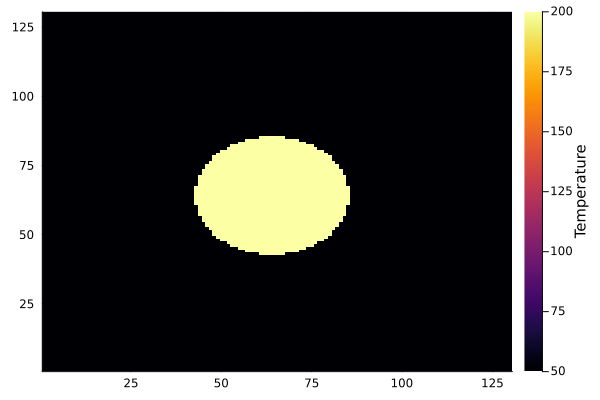

  0.021034 seconds (6.50 k allocations: 203.156 KiB)


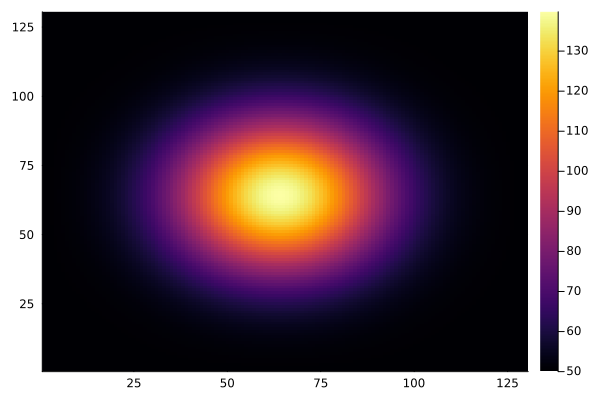

In [50]:
# Let's run this on CPU
#p = Progress(nsteps)
display(heatmap(T, colorbar_title="Temperature"))
@time for i=1:nsteps
    evolve!(T, T_prev, dx, dy, α, dt, N)
    tmp = T
    T = T_prev
    T_prev = tmp # Swap T and T_prev
    #next!(p)
end
display(heatmap(T))

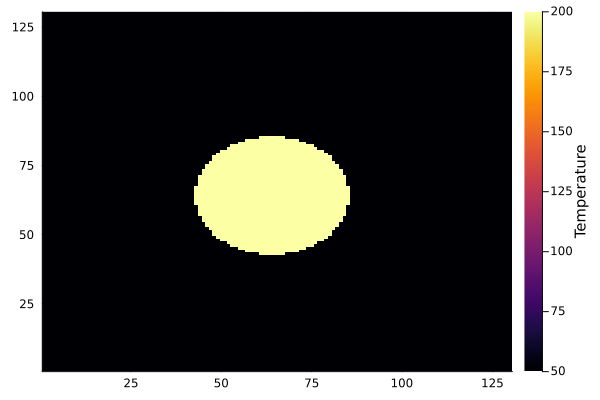

  0.007319 seconds (49.01 k allocations: 2.033 MiB)


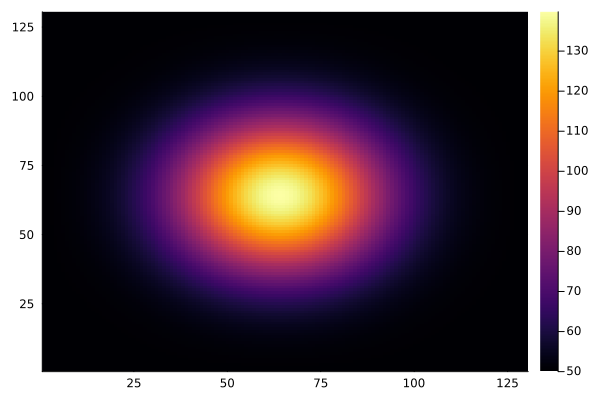

In [51]:
# Now let's do the same thing on GPU
T = zeros(N+2,N+2) .+ T_domain # Initial condition everywhere
# Now we can add our hot disk
r²= (N/6)^2
for i = 1:N+2
    for j = 1:N+2
        ds² = (i - N/2)^2 + (j - N/2)^2
        if ds² < r²
            T[i,j] = T_disk
        end
    end
end

T_prev = copy(T); # We will need the old timestep to do time marching

T_d = ROCArray(T);
T_prev_d = ROCArray(T_prev);
display(heatmap(T, colorbar_title="Temperature"))
@time for i=1:nsteps
    evolve!(T_d, T_prev_d, dx, dy, α, dt, N)
    #heatmap!(T)
    tmp_d = T_d;
    T_d = T_prev_d;
    T_prev_d = tmp_d; # Swap T and T_prev
    #next!(p)
end
display(heatmap(Array(T_d)))


- We just used the exact same code to run both on CPU and GPU!
- We got a ~12x speedup without any finetuning
- If needed, we can do better:
  - Take advantage of local/shared memory to avoid reading from global memory several times
  - Finetune workgroup size
  - ...

# 4. Julia packages for machine learning

The `MLJ.jl` (https://github.com/alan-turing-institute/MLJ.jl) package provides a unified interface to common machine learning algorithms, which include `generalized linear models`, `decision trees`, and `clustering`.

`Flux.jl` (https://github.com/FluxML/Flux.jl) and `Knet.jl` (https://github.com/denizyuret/Knet.jl) are powerful packages for Deep Learning.

Packages such as `Metalhead.jl`(https://github.com/FluxML/Metalhead.jl), `ObjectDetector.jl`(https://github.com/r3tex/ObjectDetector.jl), and `TextAnalysis.jl`(https://github.com/JuliaText/TextAnalysis.jl) provide ready to use pre-trained models for common tasks.

`AlphaZero.jl`(https://github.com/jonathan-laurent/AlphaZero.jl) provides a high performance implementation of the reinforcement learning algorithms from AlphaZero.

`Turing.jl`(https://turinglang.org/stable/) is a best in class package for probabilistic programming.

More packages for AI & ML from Julia official website
- ML: https://juliapackages.com/c/machine-learning
- NLP: https://juliapackages.com/c/nlp
- Neural Networks: https://juliapackages.com/c/neural-networks
- Reinforcement Learning: https://juliapackages.com/c/reinforcement-learning
- Supervised Learning: https://juliapackages.com/c/supervised-learning

### Training a deep neural network to classify penguins using `Flux.jl`

Flux.jl comes “batteries-included” with many useful tools built in, but also enables the user to write own Julia code for DL components.
- Flux has relatively few explicit APIs for features like regularisation or embeddings.
- All of Flux is straightforward Julia code and it can be worth to inspect and extend it if needed.
- Flux works well with other Julia libraries, like dataframes, images and differential equation solvers. One can build complex data processing pipelines that integrate Flux models.

To train a model we need four things:
- A collection of data points that will be provided to the objective function.
- A objective (cost or loss) function, that evaluates how well a model is doing given some input data.
- The definition of a model and access to its trainable parameters.
- An optimiser that will update the model parameters appropriately.

In [ ]:
using Pkg

Pkg.add("Flux")
Pkg.add("MLJ")
Pkg.add("DataFrames")
Pkg.add("PalmerPenguins")
Pkg.add("StatsBase")

In [ ]:
using Flux
using MLJ: partition, ConfusionMatrix
using DataFrames
using PalmerPenguins

table = PalmerPenguins.load()
df = DataFrame(table)
dropmissing!(df)

In [ ]:
# Pre-processing of the Penguins dataset and making it suitable for training a network.

# select feature and label columns
X = select(df, Not([:species, :sex, :island]))
Y = df[:, :species]

# split into training and testing parts
(xtrain, xtest), (ytrain, ytest) = partition((X, Y), 0.8, shuffle=true, rng=123, multi=true)

# use single precision and transpose arrays
xtrain, xtest = Float32.(Array(xtrain)'), Float32.(Array(xtest)')

# one-hot encoding
ytrain = Flux.onehotbatch(ytrain, ["Adelie", "Gentoo", "Chinstrap"])
ytest = Flux.onehotbatch(ytest, ["Adelie", "Gentoo", "Chinstrap"])

# count penguin classes to see if it's balanced
sum(ytrain, dims=2)
sum(ytest, dims=2)

In [ ]:
# We define `model` to be the neural network.

n_features, n_classes, n_neurons = 4, 3, 10
model = Chain(
        Dense(n_features, n_neurons),
        BatchNorm(n_neurons, relu),
        Dense(n_neurons, n_classes),
        softmax)

In [ ]:
# Define a `loss` function which will be minimized during training.
# Herein we use cross-entropy loss function typically used for classification
loss(x, y) = Flux.crossentropy(model(x), y)

# Define another function presenting the accuracy of the model
# onecold (opposite to onehot) gives back the original representation
function accuracy(x, y)
    return sum(Flux.onecold(model(x)) .== Flux.onecold(y)) / size(y, 2)
end

# check accuracy before training
accuracy(xtrain, ytrain)
accuracy(xtest, ytest)

In [ ]:
using StatsBase: sample

# Instead of training the entire dataset, training data were divided into `minibatches` and 
# update network weights on each minibatch separately.
function create_minibatches(xtrain, ytrain, batch_size=32, n_batch=10)
    minibatches = Tuple[]
    for i in 1:n_batch
        randinds = sample(1:size(xtrain, 2), batch_size)
        push!(minibatches, (xtrain[:, randinds], ytrain[:,randinds]))
    end
    return minibatches
end

In [ ]:
# We define an anonymous `callback` function to pass into the training function to monitor the progress, 
# to select standard ADAM optimizer, and to extract parameters of the model.

callback = () -> @show(loss(xtrain, ytrain))
opt = ADAM()
θ = Flux.params(model)

In [ ]:
# Here is to create the `minibatches` to call the `create_minibatches` function defined above.
minibatches = create_minibatches(xtrain, ytrain)

# We run 100 epochs to train the model.
for i in 1:100
    # train on minibatches
    Flux.train!(loss, θ, minibatches, opt, cb = Flux.throttle(callback, 1));
end

In [ ]:
# check final accuracy

accuracy(xtrain, ytrain)
accuracy(xtest, ytest)

In [ ]:
# Finally we create a confusion matrix to quantify the performance of the model.

predicted_species = Flux.onecold(model(xtest), ["Adelie", "Gentoo", "Chinstrap"])
true_species = Flux.onecold(ytest, ["Adelie", "Gentoo", "Chinstrap"])
ConfusionMatrix()(predicted_species, true_species)